<a href="https://colab.research.google.com/github/teamgaon/KLUE/blob/main/220218_sm_roberta_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
# k80 -> T4 -> P100

Fri Feb 18 05:58:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive




### Load Data
Data가 위치한 PATH에서 Data를 불러오기

In [10]:
PATH =  '/content/drive/MyDrive/KLUE'
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')

dev_ko = pd.read_csv('/content/drive/MyDrive/KLUE/xnli.dev.ko.tsv', sep='\t', encoding='utf-8')
test_ko = pd.read_csv('/content/drive/MyDrive/KLUE/xnli.test.ko.tsv', sep='\t', encoding='utf-8')

temp = pd.read_csv(os.path.join(PATH, 'train_data.csv'), encoding='utf-8')

In [ ]:
dev_ko

In [11]:
train = pd.concat([dev_ko,test_ko])
train.rename(columns = {'sentence1':'premise','sentence2':'hypothesis','gold_label':'label'},inplace=True)
train = pd.concat([temp, train], axis=0)
train = train.dropna()
train = train.reset_index(drop=True)
train['index'] = train.index
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
24993,24993,"오페라에 비하여 오라토리오에서는 독창보다도 합창이 중시되며, 테스토 또는 이스토리쿠...",오라토리오에서 테스토의 역할이 가장 중요하다.,neutral
24994,24994,지하철역까지 걸어서 5분 정도 걸립니다.,지하철역까지 도보로 5분 정도 걸립니다.,entailment
24995,24995,한편 이날 중앙방역대책본부는 집단 감염이 발생한 음식점 관련 역학조사 결과를 공개했다.,중악방역대책본부는 집단 감염과 관련한 모든 정보를 비공개했다.,contradiction
24996,24996,마미손이 랩을 하자 시청자들은 그의 정체를 파악했다.,시청자들은 마미손의 정체를 안다.,entailment


In [13]:
print('Train Null: ', train.isnull().sum(), sep='\n', end='\n\n')
print('Test Null: ', test.isnull().sum(), sep='\n')

Train Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64

Test Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64


### Label 분포
Train Dataset의 Label 분포를 Bar Chart를 사용하여 시각화

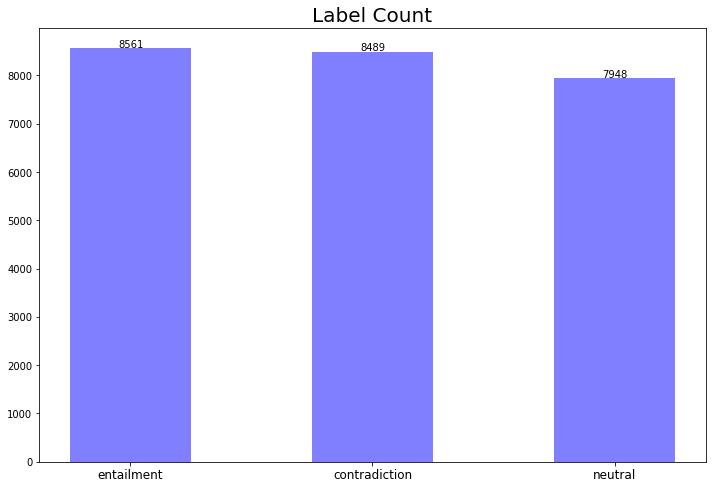

In [14]:
feature = train['label']

plt.figure(figsize=(10,7.5))
plt.title('Label Count', fontsize=20)

temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.text(-0.05, temp.values[0]+20, s=temp.values[0])
plt.text(0.95, temp.values[1]+20, s=temp.values[1])
plt.text(1.95, temp.values[2]+20, s=temp.values[2])

plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

### 전제, 가설 길이 확인
Train에 존재하는 Premise(전제), Hypothesis(가설)의 길이를 확인하고 이를 통해 Tokenizer의 max_length 설정이 가능

In [19]:
max_len = np.max(train['premise'].str.len())
min_len = np.min(train['premise'].str.len())
mean_len = np.mean(train['premise'].str.len())

print('Max Premise Length: ', max_len)
print('Min Premise Length: ', min_len)
print('Mean Premise Lenght: ', mean_len, '\n')

max_len = np.max(train['hypothesis'].str.len())
min_len = np.min(train['hypothesis'].str.len())
mean_len = np.mean(train['hypothesis'].str.len())

print('Max Hypothesis Length: ', max_len)
print('Min Hypothesis Length: ', min_len)
print('Mean Hypothesis Lenght: ', mean_len)

Max Premise Length:  90
Min Premise Length:  19
Mean Premise Lenght:  45.406552524201935 

Max Hypothesis Length:  103
Min Hypothesis Length:  5
Mean Hypothesis Lenght:  24.924433954716378


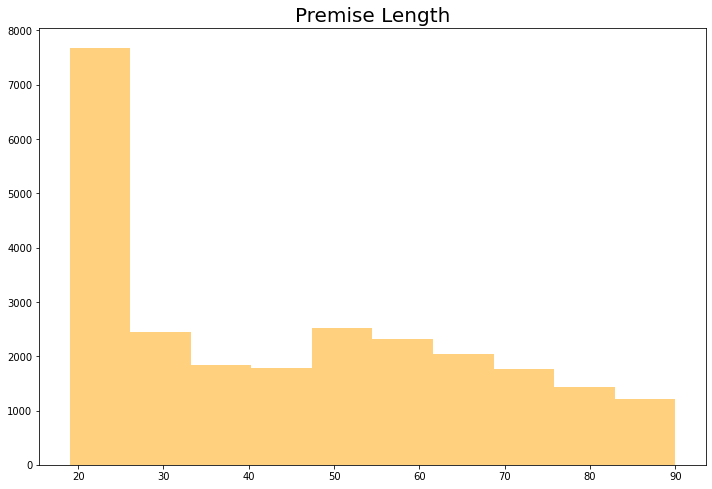

In [21]:
from collections import Counter

plt.figure(figsize=(10,7.5))
plt.title('Premise Length', fontsize=20)

plt.hist(train['premise'].str.len(), alpha=0.5, color='orange')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정

plt.show()

### 간단한 Test Preprocessing
전제, 가설에 존재하는 한글 단어가 아닌 다른 단어들은 전부 제거해줍니다.

In [22]:
train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [23]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


## Modeling

### Download transformers and Import Package

In [24]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 54.6 MB/s 
     |████████████████████████████████| 6.8 MB 66.5 MB/s 
     |████████████████████████████████| 596 kB 70.7 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [25]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

### Seed 고정, GPU 설정

In [26]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load Tokenizer, Model
Hugging Face Hub에 존재하는 Pretrained Tokenizer와 Model 및 Model Config를 불러옵니다.

이 때, Classification은 num_labels가 2로 Default되어있기 때문에 Model Config의 Parameter를 변경해줍니다.

In [27]:
MODEL_NAME = 'klue/roberta-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

print(model)
print(config)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

### Tokenizing
Train Data를 Train과 Validation Dataset으로 나누고 각각 데이터를 Tokenizer를 통해 Tokenizing을 합니다.

Tokenizer에 들어가는 문장은 전제와 가설을 Concat한 문장이 됩니다.

In [28]:
train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=False)

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

tensor([    0, 14441,  2073, 12382, 13169,  2200,  3797, 21505,  9005,  2259,
         3997,  2031,  2079,  3661, 31221,  5845,  2200,  2112,  5950, 15351,
        17788,  7285,   748,  2088, 22048,  2470,  1132, 21893, 15351,  6481,
        27135,  5417,  4084,  1972,  2145, 17524,  2138, 15526,  2259,   575,
        28674,     2, 14441,  2079,  3883,  2031,  2079,  5845, 28674,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])
[CLS] 씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 넓고 평평한 백사장이나 마당에서 모여 서로 힘과 슬기를 겨루는 것이다 [SEP] 씨름의 여자들의 놀이이다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [29]:
train_dataset

,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral
...,...,...,...,...
19993,19993,그러나 법으로 대응할 생각은 없습니다,그러나 법으로 대응할 생각은 하지 않고 있습니다,entailment
19994,19994,아무리 복수라지만 사람을 둘이나 죽인 유령이 천국에 갈 수 있는 건지 이해할 수 없...,복수는 전혀 나오지 않는 영화,contradiction
19995,19995,정부가 인플루엔자 예방접종 무료지원 대상자를 1900만명으로 확대한다,정부는 인플루엔자 예방접종 무료대상자를 늘린다,entailment
19996,19996,택시나 화물차의 경우 시범운행 기술개발 등을 토대로 추후 보조금 단가를 산정할 필요...,국토부 관계자는 택시나 화물차는 내년에 보조금 단가를 산정할 필요가 있다고 설명했다,neutral


In [30]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [31]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [32]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(5218))
print(tokenizer.decode(train_dataset.__getitem__(5218)['input_ids']))

19998
{'input_ids': tensor([    0,  3646,  2489,  2092,  4917,  2522, 15618,  2079,  6322,  2859,
         2124,   886, 16271,  4745,  2138,  4811,    27,  2429,  2299,  2118,
         6476,  2069,  5029,  2085,  3716, 28674,     2,  4913,  2118,  2377,
         4194,  2154,  2052, 16271,  4745, 28674,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [34]:
training_ars = TrainingArguments(
    output_dir='./result',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps = 500,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
model.save_pretrained('./result/best_model')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19998
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 6250


Step,Training Loss,Validation Loss,Accuracy
500,0.575900,0.428770,0.850800


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to ./result/checkpoint-500
Configuration saved in ./result/checkpoint-500/config.json
Model weights saved in ./result/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./result/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./result/checkpoint-500/special_tokens_map.json


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = './result/checkpoint-7500'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

In [ ]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

In [ ]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

In [ ]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

In [ ]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('/content/drive/MyDrive/KLUE/submission.csv', index=False)

print(df)

1. 데이터셋 만들기
2. 토크나이저 만들기
3. BERTDataset 만들기
4. 학습 파라미터 선언하기
5. 데이터로더 만들기
6. 모델 만들기
7. 매트릭스 만들기
8. 학습하기
9. 추론하기